In [474]:
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torchvision
import cv2
from ZeroShotDataset import ZeroShotDataset
from params import *

from transformers import CLIPProcessor, CLIPModel

from ConditionedSegFormerPE import ConditionedSegFormer
from LossFunc import *
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import torchmetrics as tm
from torch.utils.data import DataLoader, Dataset

# pytorch random train test split
from torch.utils.data import random_split

In [475]:
class CLIPConditionedSegFormer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.clip = CLIPModel.from_pretrained('openai/clip-vit-base-patch16')
        self.processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch16')

        self.segformer = ConditionedSegFormer(
            ModelParams.INCHANNELS,
            ModelParams.WIDTHS,
            ModelParams.DEPTHS,
            512,
            768,
            ModelParams.PATCH_SIZES,
            ModelParams.OVERLAP_SIZES,
            ModelParams.NUM_HEADS,
            ModelParams.EXPANSION_FACTORS,
            ModelParams.DECODER_CHANNELS,
            ModelParams.SCALE_FACTORS
        )

        self.plot_every = TrainParams.PLOT_EVERY

        self.neloss = NELoss(LossParams.ALPHA, LossParams.BETA)
        # self.neloss = FocalLoss()

        self.acc = tm.Accuracy(task="binary", threshold=LossParams.THRESHOLD)
        self.dice = DiceLoss()
        self.iou = IoULoss(LossParams.THRESHOLD)
        self.f1score = tm.F1Score(task="binary", threshold=LossParams.THRESHOLD)

        # freeze CLIP
        for param in self.clip.parameters():
            param.requires_grad = False

    def forward(self, x, condition):
        condition = self.clip.text_model(condition).last_hidden_state
        pe = self.clip.vision_model(x).last_hidden_state

        out = self.segformer(x, pe, condition)
        return out
    
    def training_step(self, batch, batch_idx):
        x, condition, y = batch
        y_hat = self(x, condition)
        loss = self.neloss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        
        if self.global_step % self.plot_every == 0: 
            y = y.repeat(1, 3, 1, 1)
            y_hat = torch.sigmoid(y_hat)
            y_hat = y_hat.repeat(1, 3, 1, 1)

            # x_grid = torchvision.utils.make_grid(train_dataset.image_inverse_transform(x))
            # self.logger.experiment.add_image('train_sample_image', x_grid, self.global_step)
            grid = torchvision.utils.make_grid(torch.cat([y, y_hat], dim=0))
            self.logger.experiment.add_image('train_sample_mask', grid, self.global_step)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, condition, y = batch
        y_hat = self(x, condition)
        loss = self.neloss(y_hat, y)

        t_y_hat = torch.where(y_hat > 0.5, 1, 0).long().view(-1)
        t_y = torch.where(y > 0.5, 1, 0).long().view(-1)

        acc = self.acc(t_y_hat, t_y)
        dice = self.dice(y_hat, y)
        iou = self.iou(y_hat, y)
        f1 = self.f1score(t_y_hat, t_y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_dice", dice, prog_bar=True)
        self.log("val_iou", iou, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, condition, y = batch
        y_hat = self(x, condition)

        t_y_hat = torch.where(y_hat > 0.5, 1, 0).long().view(-1)
        t_y = torch.where(y > 0.5, 1, 0).long().view(-1)

        acc = self.acc(t_y_hat, t_y)
        dice = self.dice(y_hat, y)
        iou = self.iou(y_hat, y)
        f1 = self.f1score(t_y_hat, t_y)

        self.log("test_acc", acc, prog_bar=True)
        self.log("test_dice", dice, prog_bar=True)
        self.log("test_iou", iou, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-7)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.99)
        return {
            "optimizer": optimizer, 
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }         
        }

In [476]:
tests_params = {
    'Unseen' : {
        'filter_unseen' : True,
        'filter_seen' : False
    },
    'Seen' : {
        'filter_unseen' : False,
        'filter_seen' : True
    },
    'All' : {
        'filter_unseen' : False,
        'filter_seen' : False
    }
}

In [477]:
def test(model, params, dataset_params):
    # add params to dataset params
    dataset_params['filter_unseen'] = params['filter_unseen']
    dataset_params['filter_seen'] = params['filter_seen']
    ds = ZeroShotDataset(**dataset_params)

    loader = DataLoader(ds, batch_size=TrainParams.BATCH_SIZE, num_workers=1, shuffle=True, collate_fn=ds.collate_fn)
    trainer = pl.Trainer(accelerator='gpu', max_epochs=1)

    results = trainer.test(model, dataloaders=loader)
    return results

In [478]:
def test_model(model, dataset_params, tests_params):
    df = pd.DataFrame(columns=['test', 'acc', 'dice', 'iou', 'f1'])
    for test_name, params in tests_params.items():
        results = test(model, params, dataset_params)
        df = df.append({
            'test' : test_name,
            'acc' : results[0]['test_acc'],
            'dice' : results[0]['test_dice'],
            'iou' : results[0]['test_iou'],
            'f1' : results[0]['test_f1']
        }, ignore_index=True)

    return df

In [479]:
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch16')

In [480]:
model = CLIPConditionedSegFormer()
model.load_state_dict(torch.load("transformer-epoch=09-val_loss=0.11.ckpt")["state_dict"])
model = model.eval()

In [481]:
df = pd.read_csv('ProcessedDatasetStuff/csv/val.csv')

In [482]:
dataset_params = {
    'df': df,
    'image_folder': 'ProcessedDatasetStuff/images/val/',
    'mask_folder': 'ProcessedDatasetStuff/masks/val/',
    'mask_size': 56,
    'templates': TrainParams.TEMPLATES, 
    'unseen_classes': TrainParams.UNSEEN_CLASSES, 
    'image_processor': clip_processor, 
    'tokenizer': clip_processor.tokenizer
}

In [483]:
# test_df = test_model(model, dataset_params, tests_params)

In [484]:
unseen_ds_params = dataset_params.copy()
unseen_ds_params['filter_unseen'] = True
unseen_ds_params['filter_seen'] = False

unseen_ds = ZeroShotDataset(**unseen_ds_params)

In [485]:
image, condition, mask = unseen_ds[452]
# condition = clip_processor.tokenizer.encode("a photo of a tv")
# condition = torch.tensor(condition).long()
pred = model(image.unsqueeze(0), condition.unsqueeze(0))
pred = torch.sigmoid(pred)

In [486]:
clip_processor.tokenizer.decode(condition)

'<|startoftext|>this is one horse in the scene. <|endoftext|>'

In [487]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


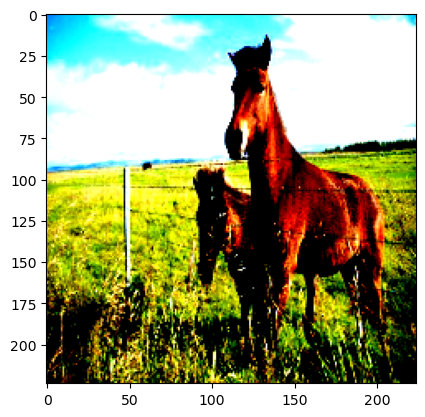

In [488]:

plt.imshow(image.permute(1, 2, 0))

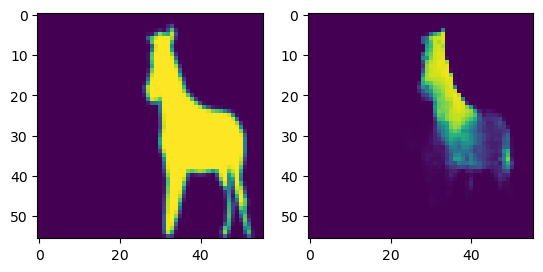

In [489]:
plt.subplot(1, 2, 1)
# set range to [0,1] for matplotlib
plt.imshow(mask[0], vmin=0, vmax=1)
plt.subplot(1, 2, 2)
plt.imshow(pred[0][0].detach().numpy(), vmin=0, vmax=1)